In [14]:
# Imports
from __future__ import print_function

import os
import time

import dgl
import networkx as nx
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
from sklearn.model_selection import train_test_split

import ipdb
import h5py
import pickle
import argparse
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random

import utils.io as io
from model.cnn_model import HOCNN
from datasets import metadata
from utils.vis_tool import vis_img
from datasets.hico_constants import HicoConstants
from datasets.hico_dataset import HicoDataset, collate_fn

import json
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Define data paths
TRAIN_IMG_PATH = "datasets/hico/images/train2015/"
TRAIN_POSE_PATH = "datasets/human_pose/train2015/"

In [3]:
# Setup training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('training on {}'.format(device))

training on cuda


In [23]:
# Define arguments
lr = 0.00001
batch_size = 32
epochs = 300

feat_type = 'fc7'
data_aug = False
exp_ver = 'v1'
save_dir = './log/hico'
log_dir = './checkpoints/hico'
save_every = 10
print_batch_every = 250
print_epoch_every = 1

In [5]:
# Define dataloaders
data_const = HicoConstants(feat_type=feat_type)

train_dataset = HicoDataset(data_const=data_const, subset='train', data_aug=data_aug)
val_dataset = HicoDataset(data_const=data_const, subset='val', data_aug=False, test=True)
dataset = {'train': train_dataset, 'val': val_dataset}
print('set up dataset variable successfully')

train_dataloader = DataLoader(dataset=dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_dataloader = DataLoader(dataset=dataset['val'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
dataloader = {'train': train_dataloader, 'val': val_dataloader}
print('set up dataloader successfully')

Using fc7 feature...
Using fc7 feature...
set up dataset variable successfully
set up dataloader successfully


In [6]:
# Define model
model = HOCNN().to(device)

In [7]:
# Display parameter information
parameter_num = 0
for param in model.parameters():
    parameter_num += param.numel()
print(f'The parameters number of the model is {parameter_num / 1e6} million')

The parameters number of the model is 49.470376 million


In [8]:
# Define loss function
criterion = nn.CrossEntropyLoss()

In [9]:
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=0)

In [50]:
# Setup visualization
writer = SummaryWriter(log_dir=log_dir + '/' + exp_ver + '/' + 'epoch_train')
io.mkdir_if_not_exists(os.path.join(save_dir, exp_ver, 'epoch_train'), recursive=True)

Training has started!


/home/jimmyl02/.conda/envs/Interact/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


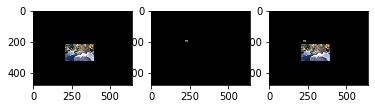

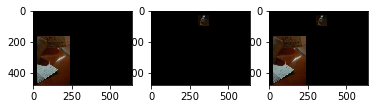

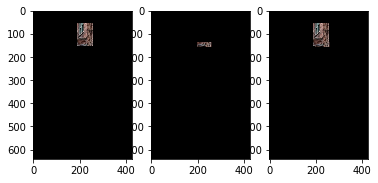

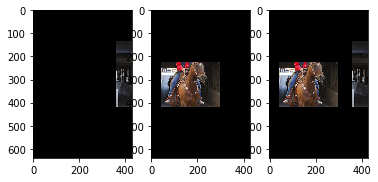

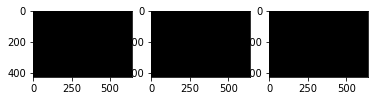

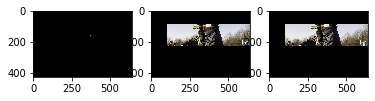

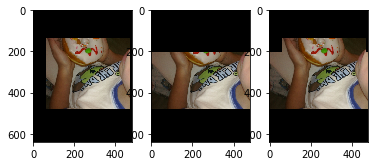

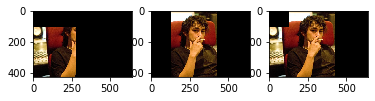

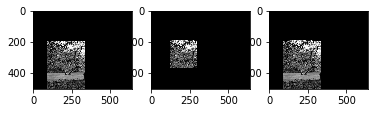

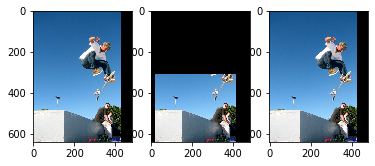

KeyboardInterrupt: 

In [51]:
# Training loop
with open('datasets/processed/hico/anno_list.json') as f:
    anno_list = json.load(f)
    
print('Training has started!')
    
for epoch in range(epochs):
    epoch_loss = 0
    for phase in ['train', 'val']:
        start_time = time.time()
        running_loss = 0.0
        idx = 0
        
        for data in dataloader[phase]:
            train_data = data
            img_name = train_data['img_name']
            
            if phase == 'train':
                # Initial train loop
                model.train()
                model.zero_grad()
                # Forward pass: human, objects, pairwise streams
                labels = np.zeros((batch_size, 600))
                for i in range(batch_size):
                    # Get image data
                    parsed_img_name = img_name[i].split(".")[0]
                    img = [x for x in anno_list if x['global_id'] == parsed_img_name][0]
                    img = img['hois'][0]
                    img_id = int(img['id']) - 1
                    labels[i][img_id] = 1
                    human_bboxes = img['human_bboxes']
                    object_bboxes = img['object_bboxes']
                    
                    # Get pose data

                    # Apply masks to images
                    src = cv2.imread(TRAIN_IMG_PATH + 'HICO_train2015_' + img['id'].rjust(8, '0') + '.jpg')
                    human_mask = np.zeros_like(src)
                    for bbox in human_bboxes:
                        cv2.rectangle(human_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
                    human_bbox_img = cv2.bitwise_and(src, human_mask, mask=None)

                    obj_mask = np.zeros_like(src)
                    pairwise_mask = human_mask
                    for bbox in object_bboxes:
                        cv2.rectangle(obj_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
                        cv2.rectangle(pairwise_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
                    obj_bbox_img = cv2.bitwise_and(src, obj_mask, mask=None)
                    pairwise_bbox_img = cv2.bitwise_and(src, pairwise_mask, mask=None)

                    
                    # Visualization of masks
                    f, axarr = plt.subplots(1,3)
                    
                    human_bbox_rgb = cv2.cvtColor(human_bbox_img, cv2.COLOR_BGR2RGB)
                    axarr[0].imshow(human_bbox_rgb)
                    
                    object_mask_rgb = cv2.cvtColor(obj_bbox_img, cv2.COLOR_BGR2RGB)
                    axarr[1].imshow(object_mask_rgb)
                    
                    pairwise_rgb = cv2.cvtColor(pairwise_bbox_img, cv2.COLOR_BGR2RGB)
                    axarr[2].imshow(pairwise_rgb)
                    
                    plt.show()
                    f.clf()
                    

                    human_bbox_img = cv2.resize(human_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
                    obj_bbox_img = cv2.resize(obj_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
                    pairwise_bbox_img = cv2.resize(pairwise_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)

                    human_bbox_img = torch.from_numpy(human_bbox_img)
                    obj_bbox_img = torch.from_numpy(obj_bbox_img)
                    pairwise_bbox_img = torch.from_numpy(pairwise_bbox_img)

                    if i == 0:
                        res_human_input = human_bbox_img.unsqueeze(0)
                        res_obj_input = obj_bbox_img.unsqueeze(0)
                        res_pairwise_input = pairwise_bbox_img.unsqueeze(0)
                    else:
                        res_human_input = torch.cat((res_human_input, human_bbox_img.unsqueeze(0)), dim=0)
                        res_obj_input = torch.cat((res_obj_input, obj_bbox_img.unsqueeze(0)), dim=0)
                        res_pairwise_input = torch.cat((res_pairwise_input, pairwise_bbox_img.unsqueeze(0)), dim=0)

                res_human_input = res_human_input.permute([0,3,1,2]).float().to(device)
                res_obj_input = res_obj_input.permute([0,3,1,2]).float().to(device)
                res_pairwise_input = res_pairwise_input.permute([0,3,1,2]).float().to(device)
                labels = torch.from_numpy(labels).long().to(device)
                
                outputs = model.forward(res_human_input, res_obj_input, res_pairwise_input)
                loss = criterion(outputs, torch.max(labels, 1)[1])
                loss.backward()
                optimizer.step()
                
            else:
                # Evaluation after train loop
                model.eval()
                with torch.no_grad(): # Disable gradients for validation
                    outputs = model.forward(res_human_input, res_obj_input, res_pairwise_input)
                    loss = criterion(outputs, torch.max(labels, 1)[1])
                    
            # Accumulate loss of each batch (average * batch size)
            running_loss += loss.item() * batch_size
            
            # Print out status per print_batch_every
            idx += 1
            if (idx % print_batch_every) == 0:
                print("[{}] Epoch: {}/{} Batch: {}/{} Loss: {} ".format(\
                        phase, epoch+1, epochs, idx, len(dataloader[phase]), loss.item()))
            
        # Epoch loss
        epoch_loss = running_loss / len(dataset[phase])
        
        # Log trainval data for visualization
        if phase == 'train':
            train_loss = epoch_loss 
        else:
            writer.add_scalars('trainval_loss_epoch', {'train': train_loss, 'val': epoch_loss}, epoch)
            
        # Output data per print_epoch_every
        if (epoch % print_epoch_every) == 0:
            end_time = time.time()
            print("[{}] Epoch: {}/{} Loss: {} Execution time: {}".format(\
                    phase, epoch+1, epochs, epoch_loss, (end_time-start_time)))
            
    # Save the model per save_every
    if epoch_loss<0.0405 or epoch % save_every == (save_every - 1) and epoch >= (200-1):
        checkpoint = { 
                        'lr': lr,
                       'b_s': batch_size,
                 'feat_type': feat_type,
                'state_dict': model.state_dict()
        }
        save_name = "checkpoint_" + str(epoch+1) + '_epoch.pth'
        torch.save(checkpoint, os.path.join(save_dir, exp_ver, 'epoch_train', save_name))
        
print('Finishing training!')

In [39]:
# Close visualization
writer.close()